In [219]:
import numpy as np
from random import random, uniform, seed
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import os

In [220]:
data = np.loadtxt('Nbody0.01.txt')

In [221]:
for i in range(3,10):
    try:
        newdata = np.loadtxt('Nbody{0}.txt'.format(10**(-i)))
        for row in newdata:
            replaceseed = int(row[0])
            data[replaceseed] = row
    except:
        pass

In [223]:
seeds, Nbodymind1s, Nbodymind2s, mind0s, mratios, ebinarys, codes = data.T
seeds = np.array([int(seed) for seed in seeds])

# Check that all the mind values got updated from their initial value. Sum should be 0

In [224]:
(Nbodymind1s==mind0s).sum()

0

In [225]:
(Nbodymind2s==mind0s).sum()

0

# Distributions of outcomes. 0 = survived, 1 = collision, 2 = ejection

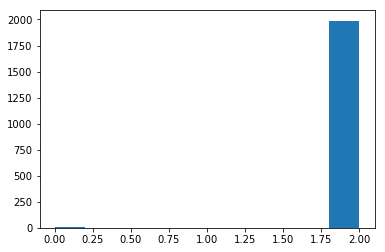

In [226]:
bins, vals, patches = plt.hist(codes)

In [227]:
print("{0}/{1} = {2:.4f} survived".format((codes==0).sum(), len(codes), (codes==0).sum()/float(len(codes))))
print("{0}/{1} = {2:.4f} collided".format((codes==1).sum(), len(codes), (codes==1).sum()/float(len(codes))))
print("{0}/{1} = {2:.4f} ejected".format((codes==2).sum(), len(codes), (codes==2).sum()/float(len(codes))))

12/2000 = 0.0060 survived
0/2000 = 0.0000 collided
1988/2000 = 0.9940 ejected


# Distribution of minimum distances (from both stars combined, not necessarily the star that ejected the body)

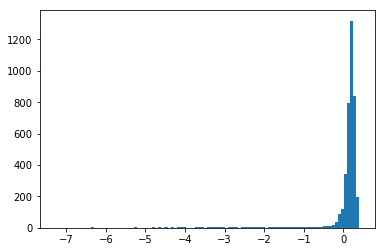

In [230]:
bins, vals, patches = plt.hist(np.log10(np.concatenate((Nbodymind1s, Nbodymind2s))), bins=100)

# Dimensionalize

Iterate following procedure

- Draw a primary from the IMF (I think this should be the single star IMF, not the system mass IMF, unless the mass ratio distribution is the same for all of the Duchene & Kraus bins in which case we can draw a system mass as above)
- Determine which of the Duchene & Kraus bins that primary falls into
- Draw from single/binary according to the binary fraction at that mass range.  If the primary is single add the mass to a 'single/wide binary' bin and return to 1.
- Draw a mass ratio, eccentricity and separation from the appropriate Duchene & Kraus distributions
- If the separation is larger than our wide binary cut off, add the mass to the 'single/wide binary' bin and return to 1.
- From the eccentricity and separation calculate the critical instability distance
- Use the mass-luminosity relation fit for both the primary and secondary to calculate the snow line distance

- Calculate a_ice/a_crit
- Choose a stellar type
- Draw from the System IMF in that stellar type's mass range
- Draw mind1 and mind2 from the distribution of Nbody outcomes
- Use total mass from IMF and mass ratio from Nbody simulation to calculate M1 and M2
- Draw binary separation from Duchene and Kraus and dimensionalize minds
- Calculate a_Roche and Rstar from M 

# Build a sampler

This class let's you sample from an arbitrary pdf

In [231]:
class Sampler():
    def __init__(self, values, pdf): 
        # pass np. array of x values, np.array of pdf at those values
        self.minvalue = values.min()
        self.maxvalue = values.max()
        pdf /= pdf.sum()
        cdf = np.cumsum(pdf)
        self.mincdf = cdf.min()
        self.maxcdf = cdf.max()
        self.cdffunc = interp1d(values, cdf)
        self.invcdffunc = interp1d(cdf, values)
        
        def _sample(cdfval): # returns value corresponding to when cdf matches passed value
            try:
                return self.invcdffunc(cdfval)
            except ValueError:
                if cdfval < self.mincdf:
                    return self.minvalue
                elif cdfval > self.maxcdf:
                    return self.maxvalue
        self._sample = np.vectorize(_sample)
    
    def sample(self, Nvals=1, minval=None, maxval=None):
        # returns Nvals samples from the pdf as np.array. Optionally pass range of values to sample from
        
        # if range of values is passed, calculate corresponding range of cdf values
        mincdf = self.cdffunc(minval) if minval is not None else 0.
        maxcdf = self.cdffunc(maxval) if maxval is not None else 1.
        cdfs = mincdf + (maxcdf-mincdf)*np.random.random([Nvals]) # sample Nvals cdf values in the range
        return self._sample(cdfs)

PDF for the log mass for the binary system

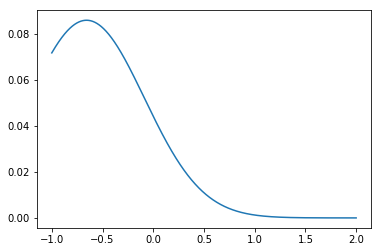

In [232]:
def logIMFChab(logM):
    IMFChab = 0.086*np.exp(-((logM-np.log10(0.22))**(2.))/(2.*0.57**2.))
    return IMFChab

starmasses = np.linspace(-1, 2, 100000)
logIMF = logIMFChab(starmasses)
plt.plot(starmasses, logIMF)
plt.show()

Example over whole range

CPU times: user 308 ms, sys: 4.13 ms, total: 313 ms
Wall time: 313 ms


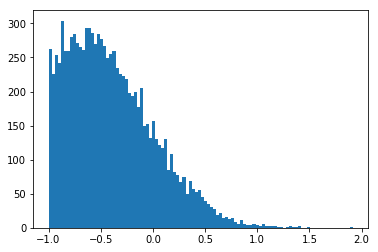

In [233]:
%%time
logIMFsampler = Sampler(starmasses, logIMF)
bins, vals, patches = plt.hist(logIMFsampler.sample(10000), bins=100)

Example over specified range

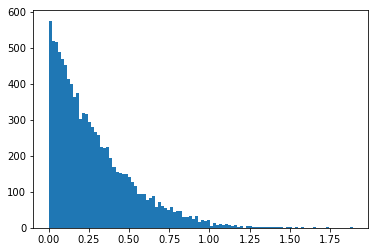

In [234]:
bins, vals, patches = plt.hist(logIMFsampler.sample(10000, 0, 2), bins=100)

# Define stellar types, mass ranges, and multiple fraction

In [276]:
# triplets of [Mmin, Mmax, fraction of systems that are multiples (MF in Duchene & Kraus)]
typemasses = {'VLM':[1.e-3, 0.1, 0.22], 'M':[0.1, 0.6, 0.26], 'FGK':[0.6, 1.4, 0.44], 'A':[1.4, 6.5, 0.5], 'OB':[6.5, 100, 0.8]}

def get_type(M):
    for key, value in typemasses.items():
        if M > value[0] and M < value[1]:
            return key
    return np.nan

# Draw a primary from the IMF (Note this is currently using the system IMF)

In [279]:
seed(0)
stellartype = 'M'

In [278]:
Mmin, Mmax, MF = typemasses[stellartype]
logMmin = np.log10(Mmin)
logMmax = np.log10(Mmax)

Msystem = 10**logIMFsampler.sample(minval=logMmin, maxval=logMmax)[0] # returns array
print(Msystem)

0.187899660664


# Draw mind1 and mind2 from the distribution of Nbody outcomes

Draw a random Nbody simulation

In [238]:
randseed = np.random.randint(len(seeds))
mind1 = Nbodymind1s[randseed]
mind2 = Nbodymind2s[randseed]
mratio = mratios[randseed] # secondary has mass mratio
print(mind1, mind2, mratio)

1.71402116373 1.59028062603 0.144239806235


# Use total mass from IMF and mass ratio from Nbody simulation to calculate M1 and M2

In [239]:
M1 = Msystem/(1.+mratio)
M2 = Msystem-M1
print(M1, M2)

0.121792341099 0.017567303681


# Draw binary separation from Duchene and Kraus and dimensionalize minds

Define Duchene & Kraus binary separation distributions

In [240]:
logabinaries = np.linspace(-2.5, 6, 10000)
def gaussianpdf(vals, mu, sigma):
    pdf = np.exp(-(vals-mu)**2/(2.*sigma**2))
    return pdf/pdf.sum()

In [241]:
logabinPDF = {}
logabinPDF['VLM'] = gaussianpdf(logabinaries, np.log10(4.5), 0.333)
logabinPDF['M'] = gaussianpdf(logabinaries, np.log10(5.3), 0.867)
logabinPDF['FGK'] = gaussianpdf(logabinaries, np.log10(45), 1.533)

tempA = gaussianpdf(logabinaries, np.log10(350), 1.533) + gaussianpdf(logabinaries, np.log10(0.2), 1.)
logabinPDF['A'] = tempA/tempA.sum()

logabinPDF['OB'] = gaussianpdf(logabinaries, np.log10(0.2), 0.1677)

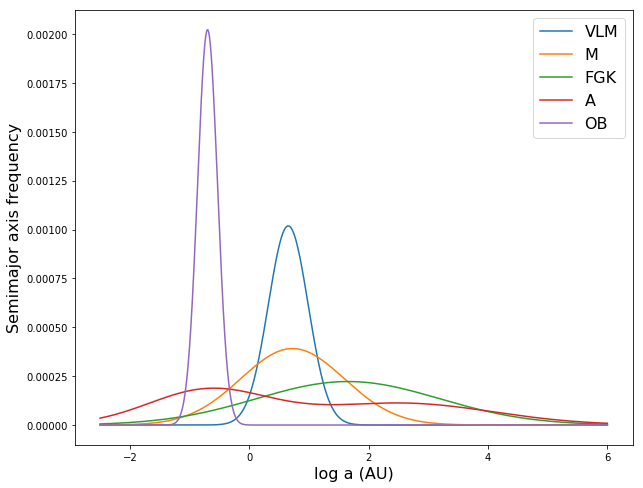

In [242]:
fig, ax = plt.subplots(figsize=(10,8))
for key, val in logabinPDF.items():
    ax.plot(logabinaries, val, label=key)
plt.legend(fontsize=16)
ax.set_xlabel('log a (AU)', fontsize=16)
ax.set_ylabel('Semimajor axis frequency', fontsize=16)

Duchene and Kraus give binary separation distributions based on primary mass, so get primary stellar type from M1 (should be same as stellartype chosen for system above in most cases)

In [243]:
primarytype = get_type(M1)
primarytype

'M'

Create sampler for particular stellartype

CPU times: user 325 ms, sys: 9.76 ms, total: 335 ms
Wall time: 329 ms


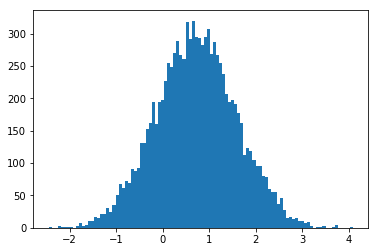

In [244]:
%%time
logabinsampler = Sampler(logabinaries, logabinPDF[primarytype])
bins, vals, patches = plt.hist(logabinsampler.sample(10000), bins=100)

In [245]:
abinary = 10**logabinsampler.sample()[0]
mind1 *= abinary
mind2 *= abinary
print(abinary, mind1, mind2)

6.00213632292 10.2877886851 9.54508110911


# Calculate a_Roche and Rstar from M

First get FitRfuncM function to get radius from mass (at 1 Myr?)

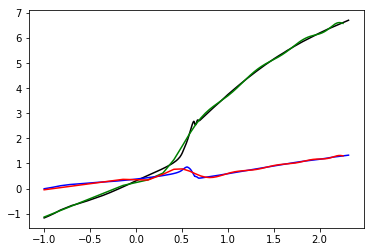

In [246]:
# Stellar tracks fits: L(M) and R(M)

# Read the stellar tracks file with pandas. This is the only file needed
tracksdf = pd.read_table('./startrackextended.txt', header=0,delimiter=r"\s+")


# Fit log_L then log_R as a function of log(mass) using polynomials
FitLfuncM = np.polyfit(np.log10(tracksdf['star_mass']), tracksdf['log_L'], 16)
FitRfuncM = np.polyfit(np.log10(tracksdf['star_mass']), tracksdf['log_R'], 20)


# Convenience function to easily call the polynomials as functions 
# These are the functions you will need to use
# example: Luminosity for a 1 solar mass star: PolyLfuncM(np.log10(1.))
# It hence takes logs and output logs
PolyLfuncM = np.poly1d(FitLfuncM)
PolyRfuncM = np.poly1d(FitRfuncM)



############################## PLOT ############################
# stellar mass array
arraytest = np.linspace(0.1,180.,len(tracksdf['log_L']))

# Compare fit and data for L func of M
plt.plot(np.log10(tracksdf['star_mass']),tracksdf['log_L'], color='black')
plt.plot(np.log10(arraytest),PolyLfuncM(np.log10(arraytest).reshape((len(arraytest),1))), color='green')

# Compare fit and data for R func of M
plt.plot(np.log10(tracksdf['star_mass']),tracksdf['log_R'], color='blue')
plt.plot(np.log10(arraytest),PolyRfuncM(np.log10(arraytest).reshape((len(arraytest),1))), color='red')

plt.show()
############################## END sPLOT ############################

In [247]:
Rsun = 5e-3 # AU
def aRoche(Mstar): # assumes fluid body (coeff of 1.26) and a bulk density for the body of 3 g/cc
    rho_sun = 1.4
    rho_body = 3
    return 1.26*Mstar**(1./3.)*(rho_sun/rho_body)**(1./3.)*Rsun # Return value in AU

def Rstar(Mstar): # Returns radius of star in AU at time interpolated in cell above
    if Mstar < 0.1: # function can't interpolate below 0.1
        Mstar = 0.1
    return 10**PolyRfuncM(np.log10(Mstar))*Rsun

In [248]:
aRoches = np.array([aRoche(10**M) for M in starmasses])/Rsun
Rstars = np.array([Rstar(10**M) for M in starmasses])/Rsun

# The Roche Limit is inside the stars for all values of the mass at 1 Myr. Presumably the Roche Limit is outside low-mass stars once they have contracted? Worth checking?

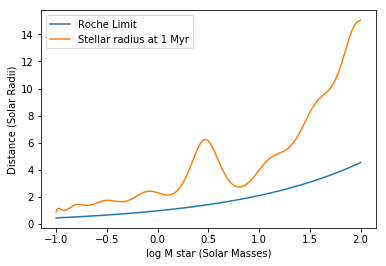

In [249]:
fig, ax = plt.subplots()
ax.plot(starmasses, aRoches, label='Roche Limit')
ax.plot(starmasses, Rstars, label='Stellar radius at 1 Myr')
ax.legend()
ax.set_xlabel('log M star (Solar Masses)')
ax.set_ylabel('Distance (Solar Radii)')

In [250]:
R1 = Rstar(M1)
R2 = Rstar(M2)
aRoche1 = aRoche(M1)
aRoche2 = aRoche(M2)
print(R1, R2, aRoche1, aRoche2)

0.00504362645654 0.0044570274198 0.00242223422365 0.00127031427779


# Put above steps all together in a function

In [251]:
def sample(stellartype=None):
    # sample system mass
    if stellartype is None:
        logMmin = -1
        logMmax = 2
    else:
        Mmin, Mmax, MF = typemasses[stellartype]
        logMmin = np.log10(Mmin)
        logMmax = np.log10(Mmax)

    Msystem = 10**logIMFsampler.sample(minval=logMmin, maxval=logMmax)[0] # returns array

    # draw random Nbody simulation and get dimensoinalized masses from Msystem
    randseed = np.random.randint(len(seeds))
    mind1 = Nbodymind1s[randseed]
    mind2 = Nbodymind2s[randseed]
    mratio = mratios[randseed] # secondary has mass mratio
    M1 = Msystem/(1.+mratio)
    M2 = Msystem-M1
    
    # get primary stellar type and create abinary sampler to get abinary and dimensionalize minds
    primarytype = get_type(M1)
    logabinsampler = Sampler(logabinaries, logabinPDF[primarytype])
    abinary = 10**logabinsampler.sample()[0]
    mind1 *= abinary
    mind2 *= abinary

    # calculate radii and roche limits
    R1 = Rstar(M1)
    R2 = Rstar(M2)
    aRoche1 = aRoche(M1)
    aRoche2 = aRoche(M2)
    
    return [abinary, mind1, mind2, R1, R2, aRoche1, aRoche2] # all in AU

In [252]:
stellartype = 'M'
sample(stellartype)

[21.419549143174805,
 19.625340665676859,
 0.65454061839810829,
 0.0092408955459176139,
 0.0044570274197973624,
 0.0040134825641160469,
 0.0015563217026192352]

# Sample a stellar type

In [263]:
%%time
stellartype = 'OB'
Nsamples = 2000
samples = np.array([sample(stellartype) for i in range(Nsamples)])
abinaries, mind1s, mind2s, R1s, R2s, aRoche1s, aRoche2s = samples.T

CPU times: user 1.78 s, sys: 47.1 ms, total: 1.83 s
Wall time: 1.87 s


# Distribution of Stellar Radii

Peak at low values for M stars is because most secondaries have M < 0.1, which is outside interpolation range for stellar radii, so they're assigned R(M=0.1)

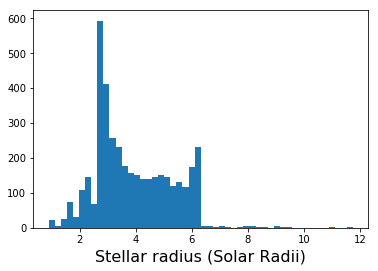

In [264]:
fig, ax = plt.subplots()
bins, vals, patches = ax.hist(np.concatenate((R1s/Rsun, R2s/Rsun)), bins=50)
ax.set_xlabel('Stellar radius (Solar Radii)', fontsize=16)

# Distribution of Roche Limits

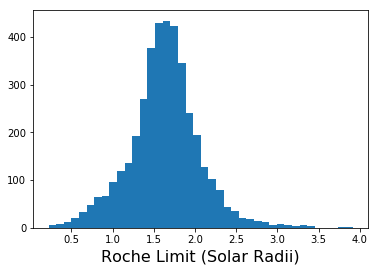

In [265]:
fig, ax = plt.subplots()
bins, vals, patches = ax.hist(np.concatenate((aRoche1s/Rsun, aRoche2s/Rsun)), bins=40)
ax.set_xlabel('Roche Limit (Solar Radii)', fontsize=16)

# Distribution of binary separations

For OB, part of the tail toward large separations is due to drawing an OB system mass, but then ending up with a primary that is an A star due to random draw of mass ratio

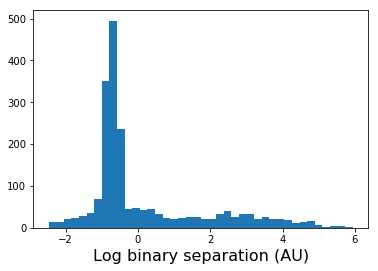

In [266]:
fig, ax = plt.subplots()
bins, vals, patches = ax.hist(np.log10(abinaries), bins=40)
ax.set_xlabel('Log binary separation (AU)', fontsize=16)

# Distribution of log min distances in units of stellar radii

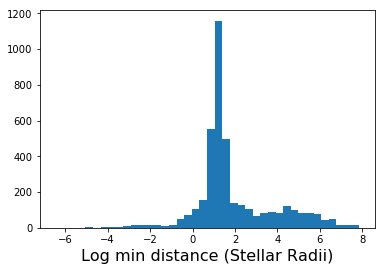

In [267]:
fig, ax = plt.subplots()
ds = np.concatenate((np.log10(mind1s/R1s), np.log10(mind2s/R2s)))
bins, vals, patches = ax.hist(ds, bins=40)
ax.set_xlabel('Log min distance (Stellar Radii)', fontsize=16)

In [268]:
print("Number of collisions = {0}/{1} = {2}".format((ds < 0).sum(), len(ds), (ds < 0).sum()/float(len(ds))))

Number of collisions = 245/4000 = 0.06125


# Distribution of log min distances in units of Roche radii

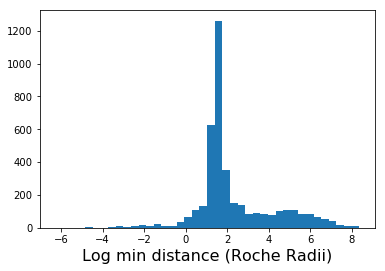

In [269]:
fig, ax = plt.subplots()
ds = np.concatenate((np.log10(mind1s/aRoche1s), np.log10(mind2s/aRoche2s)))
bins, vals, patches = ax.hist(ds, bins=40)
ax.set_xlabel('Log min distance (Roche Radii)', fontsize=16)

In [270]:
print("Number of tidal disruptions = {0}/{1} = {2}".format((ds < 0).sum(), len(ds), (ds < 0).sum()/float(len(ds))))

Number of tidal disruptions = 161/4000 = 0.04025


# Can tidal disruptions even occur?

Check how many samples had Roche radius outside stellar radius

In [271]:
fracs = np.concatenate((aRoche1s/R1s, aRoche2s/R2s))
mask = ds < 0
disruptioncandidates = fracs[mask]

In [272]:
print("{0}/{1} = {2} of the tidal disruptions were true disruptions rather than collisions (had Roche radius outside stellar radius)".format((disruptioncandidates > 1).sum(), len(disruptioncandidates), (disruptioncandidates > 1).sum()/float(len(disruptioncandidates))))

0/161 = 0.0 of the tidal disruptions were true disruptions rather than collisions (had Roche radius outside stellar radius)
